Deliverables



1. A report (in the form of a presentation, both verbal and through a slides)


2. A github repository containing your jupyter notebook that walks through the pipeline along with the .py files necessary to reproduce your model.



In [1]:
import wrangle
import pandas as pd
import numpy as np
import evaluate
import explore
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, explained_variance_score
from scipy import stats
import split_scale
import feature_selection
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import QuantileTransformer, quantile_transform
from sklearn.metrics import median_absolute_error, r2_score

In [2]:
#use wrangle.py to import data from mySQL
df =wrangle.get_data_from_sql()

In [3]:
# check DF head
df.head()

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date
0,2.0,3.0,1458.0,6037.0,8284.0,1.0,97318.0,1970.0,34686163.0,-118113100.0,136104.0,2319.90,2017-06-23
1,1.0,2.0,1421.0,6037.0,6707.0,NaN,96018.0,1911.0,33999877.0,-118291863.0,35606.0,543.69,2017-06-30
2,3.0,4.0,2541.0,6059.0,4975.0,NaN,96958.0,2003.0,33694636.0,-117912245.0,880456.0,9819.72,2017-06-01
3,2.0,3.0,1650.0,6037.0,7300.0,NaN,96037.0,1949.0,33985377.0,-118361620.0,614000.0,7673.19,2017-06-01
4,1.0,2.0,693.0,6037.0,2908.0,NaN,96023.0,1921.0,34112946.0,-118208106.0,274237.0,3267.47,2017-06-29


In [4]:
# check DF tail
df.tail()

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date
14985,3.0,5.0,2526.0,6059.0,7800.0,1.0,97018.0,1994.0,33753643.0,-117766503.0,458903.0,5718.72,2017-06-30
14986,3.0,5.0,2735.0,6059.0,7100.0,1.0,97067.0,1963.0,33783173.0,-117817799.0,115387.0,1465.88,2017-06-30
14987,2.0,3.0,1536.0,6037.0,8818.0,1.0,96523.0,1955.0,34058178.0,-117948180.0,297097.0,3519.78,2017-06-30
14988,3.0,5.0,2655.0,6059.0,6000.0,NaN,97065.0,1994.0,33836898.0,-117801369.0,746963.0,8065.50,2017-06-30
14989,3.0,4.0,2305.0,6037.0,5742.0,NaN,96129.0,1949.0,33952368.0,-118441155.0,579047.0,6996.21,2017-06-30


In [5]:
# there are null values in lot_size, pool, zip_code, year_built and tax-value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14990 entries, 0 to 14989
Data columns (total 13 columns):
bathrooms           14990 non-null float64
bedrooms            14990 non-null float64
square_feet         14990 non-null float64
fips                14990 non-null float64
lot_size            14893 non-null float64
pool                3287 non-null float64
zip_code            14982 non-null float64
year_built          14974 non-null float64
latitude            14990 non-null float64
longitude           14990 non-null float64
assessed_value      14990 non-null float64
tax_value           14989 non-null float64
transaction_date    14990 non-null object
dtypes: float64(12), object(1)
memory usage: 1.5+ MB


In [6]:
#wrangle data to remove NANs
df = wrangle.wrangle_zillow()

In [7]:
#create a new column tax-rate
df['tax_rate'] = df.tax_value/df.assessed_value

In [8]:
df.head(2)

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date,tax_rate
0,2.0,3.0,1458.0,6037,8284,1,97318,1970,34686163.0,-118113100.0,136104.0,2319.90,2017-06-23,0.017045
1,1.0,2.0,1421.0,6037,6707,0,96018,1911,33999877.0,-118291863.0,35606.0,543.69,2017-06-30,0.015270


In [9]:
#https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697
#source for county fips code. Read codes in a data DataFrame named fips_codes
#fips_codes = pd.read_clipboard()

In [10]:
fips_code = pd.DataFrame({
    'fips': [6037, 6059, 6111],
    'County':['Los Angles', 'Orange', 'Ventura']
})
fips_code.head()

,fips,County
0,6037,Los Angles
1,6059,Orange
2,6111,Ventura


In [11]:
#merge df and fips_codes 
df = pd.merge(df, fips_code, left_on='fips', right_on='fips', how='left')

In [12]:
df.head(2)

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date,tax_rate,County
0,2.0,3.0,1458.0,6037,8284,1,97318,1970,34686163.0,-118113100.0,136104.0,2319.90,2017-06-23,0.017045,Los Angles
1,1.0,2.0,1421.0,6037,6707,0,96018,1911,33999877.0,-118291863.0,35606.0,543.69,2017-06-30,0.015270,Los Angles


In [13]:
#split the data into train and test
train, test = train_test_split(df, train_size = .70, random_state = 100)

# Data Exploration (Using train data only)

In [14]:
#create a subset of df with continuous variables to create pairplot
train_plot = df[['bathrooms', 'bedrooms', 'square_feet', 'lot_size', 'assessed_value']]

In [15]:
train_plot.head(2)

,bathrooms,bedrooms,square_feet,lot_size,assessed_value
0,2.0,3.0,1458.0,8284,136104.0
1,1.0,2.0,1421.0,6707,35606.0


In [16]:
df[df.assessed_value<1000000].count()[1]/df.shape[0]

0.8911450279029113

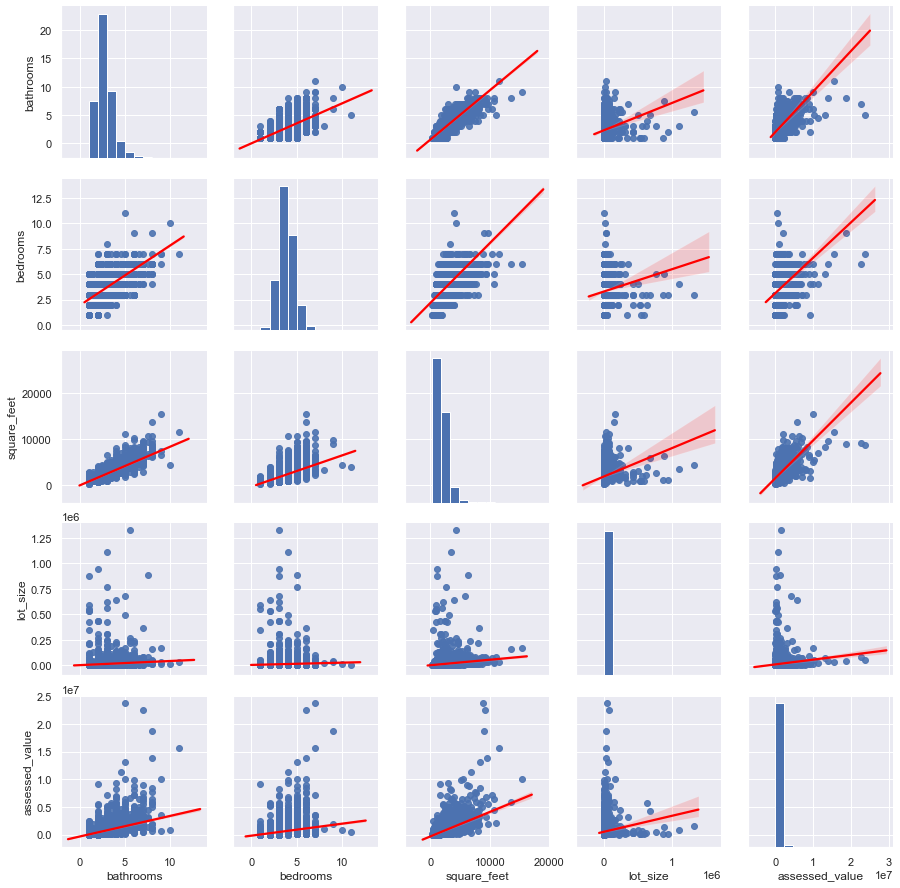

In [17]:
explore.plot_variable_pairs(train_plot)

# Home value seems to be correlated to number of bathrooms, bedrooms, square_feet and lot size

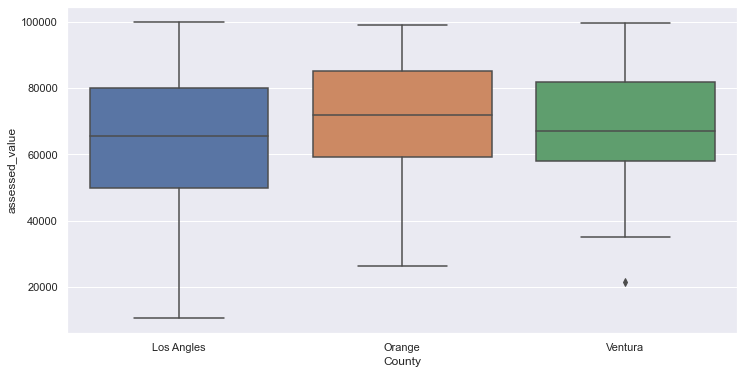

In [18]:
# Lets look at box plot of home values in each county. For better visualization, homes above 1 million are not plotted
plt.figure(figsize=(12,6))
sns.boxplot(x= train[train.assessed_value<100000].County, y= train[train.assessed_value<100000].assessed_value, data=train[train.assessed_value<100000])

In [19]:
train.head()

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date,tax_rate,County
11938,3.0,3.0,2130.0,6037,7242,1,97319,1988,34663693.0,-118185301.0,268557.0,3975.61,2017-06-22,0.014804,Los Angles
790,2.0,4.0,1705.0,6037,7412,1,96389,1960,34178821.0,-118607295.0,95849.0,1296.19,2017-05-03,0.013523,Los Angles
3846,2.0,3.0,2014.0,6037,6491,0,96246,1936,33774191.0,-118123557.0,324613.0,3968.00,2017-05-17,0.012224,Los Angles
14846,3.0,3.0,2376.0,6059,4500,0,97067,1989,33788519.0,-117766101.0,499860.0,6082.08,2017-06-30,0.012168,Orange
1469,2.0,3.0,1360.0,6037,5200,0,96012,1965,34087088.0,-118200703.0,517777.0,6302.17,2017-05-05,0.012172,Los Angles


In [20]:
# median value of homes is a better measure of central tendency for home values due to outliers.
train[train.assessed_value <1000000].assessed_value.median()

344387.0

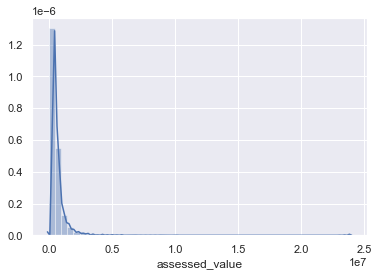

In [21]:
# plot showing distribution of home values. This looks like right skewed distribution
sns.distplot(train.assessed_value)

In [22]:
cm = train_plot.corr()
cm

,bathrooms,bedrooms,square_feet,lot_size,assessed_value
bathrooms,1.000000,0.643196,0.855253,0.140262,0.516795
bedrooms,0.643196,1.000000,0.630065,0.069576,0.273758
square_feet,0.855253,0.630065,1.000000,0.182419,0.602603
lot_size,0.140262,0.069576,0.182419,1.000000,0.116572
assessed_value,0.516795,0.273758,0.602603,0.116572,1.000000


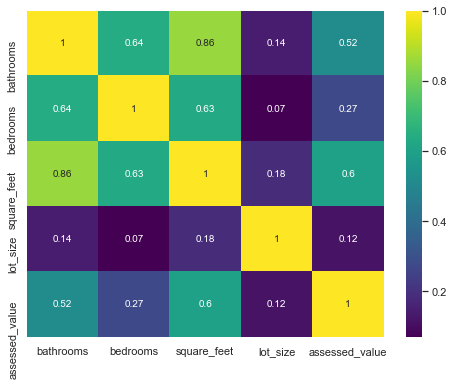

In [23]:
# lets look at heatmap and corresponding correlation values 
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap='viridis')

# $H_0$: there is no relationship between home values and number of bedrooms, bathrooms and square_feet
# $H_a$: There is a relationship between home values and number of bedrooms, bathrooms and square_feet

In [24]:
#Lets take a look at simple model based on bathoom, bedroom and squarefeet and compare if against the baseline(median home value)
X_train = train[['bedrooms', 'bathrooms', 'square_feet']]
y_train = train[['assessed_value']]
y_train['y_baseline'] = train['assessed_value'].median()

In [25]:
y_train.head()

,assessed_value,y_baseline
11938,268557.0,389610.0
790,95849.0,389610.0
3846,324613.0,389610.0
14846,499860.0,389610.0
1469,517777.0,389610.0


In [26]:
# Calculating the baseline (based on median) RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_bl = sqrt(mean_squared_error(y_train.assessed_value, y_train.y_baseline))

rmse_bl

734625.2550096865

In [27]:
#We now create a OLS model based on bedrooms, bathrooms and square_feet
from statsmodels.formula.api import ols

# generate parameters, i.e. create model
ols_model = ols('assessed_value ~ bedrooms + bathrooms + square_feet', data = train).fit()

# compute predictions and add to original dataframe
y_train['yhat'] = ols_model.predict(X_train)

In [28]:
y_train.head()

,assessed_value,y_baseline,yhat
11938,268557.0,389610.0,718051.869254
790,95849.0,389610.0,316295.362143
3846,324613.0,389610.0,606590.711377
14846,499860.0,389610.0,832519.897568
1469,517777.0,389610.0,302273.270250


In [29]:
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         assessed_value   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     2007.
Date:                Thu, 09 Apr 2020   Prob (F-statistic):               0.00
Time:                        15:55:59   Log-Likelihood:            -1.5278e+05
No. Observations:               10411   AIC:                         3.056e+05
Df Residuals:                   10407   BIC:                         3.056e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -5989.8197    2.1e+04     -0.285      0.776   -4.72e+04    3.52e+04
bedrooms    -1.465e+05   8045.351    -18.211      0.000   -1.62e+05   -1.31e+05
bathrooms    5.748e+04    1.1e+04      5.220      0.000    3.59e+04    7.91e+04
square_feet   465.3172     11.199     41.549      0.000     443.364     487.270
==============================================================================
Omnibus:                    16670.764   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         26785887.300
Skew:                          10.040   Prob(JB):                         0.00
Kurtosis:                     250.679   Cond. No.                     8.51e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.51e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Since my p-value is <0.05, I can reject my null hypothesis.
# This means that there is statistically significant relationship between home prices and  independent variables used above.

In [30]:

rmse = sqrt(mean_squared_error(y_train.assessed_value, y_train.yhat))
rmse

571669.8819642654

#  RMSE for OLS model with bedrooom, bathroom and square feet (578329) is lower than the baseline (based on median)748179.  R2 is 0.37 and p-value is 0.

# I am next going to build a simple linear regression model based on bathrooms, bedrooms and square feet

In [31]:
# make a dataframe 'predictions' with actual home values
predictions = pd.DataFrame({
    'actual': y_train.assessed_value
})
predictions.head()

,actual
11938,268557.0
790,95849.0
3846,324613.0
14846,499860.0
1469,517777.0


In [32]:
X_train1 = X_train[['bedrooms', 'bathrooms', 'square_feet']]
y_train1 = y_train[['assessed_value']]

In [33]:
#linear regression model
lm = LinearRegression()

In [34]:
# fit our train data on the model
lm.fit(X_train1, y_train1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [35]:
print("Linear Model:", lm)

print("intercept: ", lm.intercept_)

print("coefficients: ", lm.coef_)

Linear Model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
intercept:  [-5989.8196941]
coefficients:  [[-146512.33805875   57484.36403782     465.31718827]]


In [36]:
#predictions from linear regresssion model based on X_train independent variable values
predictions['yhat_lm'] = lm.predict(X_train1)

In [37]:
#Baseline predicted home value (median home price)
predictions['baseline'] = y_train.assessed_value.median()

In [38]:
predictions.head(2)

,actual,yhat_lm,baseline
11938,268557.0,718051.869254,389610.0
790,95849.0,316295.362143,389610.0


In [39]:
# Use lamda and calculate RMSE for each columns in prediction dataframe
pd.options.display.float_format = '{:.3f}'.format
predictions.apply(lambda col: sqrt(mean_squared_error(predictions.actual, col)))

actual          0.000
yhat_lm    571669.882
baseline   734625.255
dtype: float64

# The RMSE above for the linear model is better than baseline

# Lets use this model on test data and see how well it does there

In [40]:
#using test data and predicting home values based on linear model above
X_test = test[['bedrooms', 'bathrooms', 'square_feet']]
y_test = test[['assessed_value']]
y_test['test_prediction'] = lm.predict(X_test)

In [41]:
y_test.rename(columns = {'assessed_value': 'actual'}, inplace = True)

In [42]:
y_test.head(2)

,actual,test_prediction
9116,1352462.000,1043773.901
2397,797339.000,981994.199


In [43]:
#Calculating RMSE for test predictions
y_test.apply(lambda col: sqrt(mean_squared_error(y_test.actual, col)))

actual                 0.000
test_prediction   576029.145
dtype: float64

# The RMSE for test data is lower than the train data!! This linear means model is working well (atleast better than baseline)

# We will know try to explore this data more and do feature engineering to see if we can do better than the model above

Seems like most of the data is from LA county followed by Orange and then Ventura county

Text(0.5, 0, 'County')

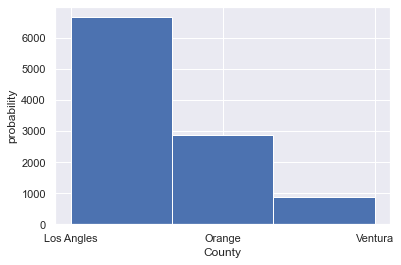

In [44]:
plt.hist(train.County, density=False, bins=3)
plt.ylabel('probability')
plt.xlabel('County')

Text(0.5, 0, 'Number of bathrooms')

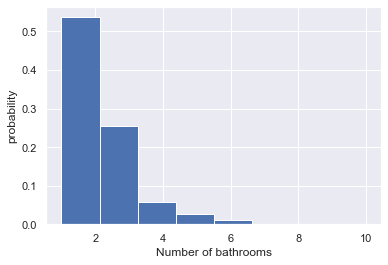

In [45]:
plt.hist(train.bathrooms, density=True, bins=8)  # `density=False` would make counts
plt.ylabel('probability')
plt.xlabel('Number of bathrooms')


Text(0.5, 0, 'Number of bedrooms')

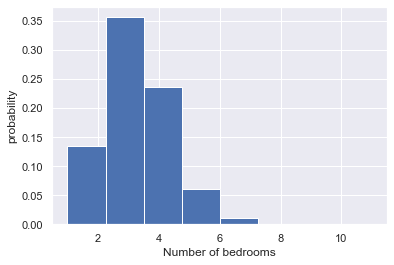

In [46]:
plt.hist(train.bedrooms, density=True, bins=8)  # `density=False` would make counts
plt.ylabel('probability')
plt.xlabel('Number of bedrooms')



Text(0.5, 0, 'Year built')

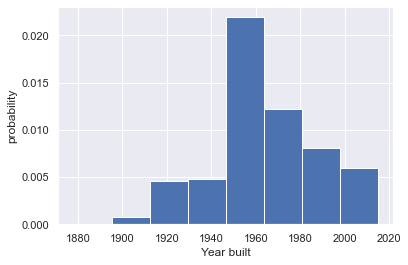

In [47]:
plt.hist(train.year_built, density=True, bins=8)  # `density=False` would make counts
plt.ylabel('probability')
plt.xlabel('Year built')

Text(0.5, 0, 'Square Feet')

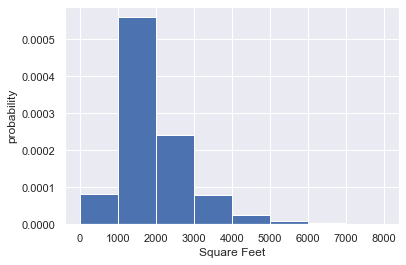

In [48]:
plt.hist(train.square_feet, density=True, bins=[0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000])  # `density=False` would make counts
plt.ylabel('probability')
plt.xlabel('Square Feet')

Text(0.5, 0, 'tax_rate')

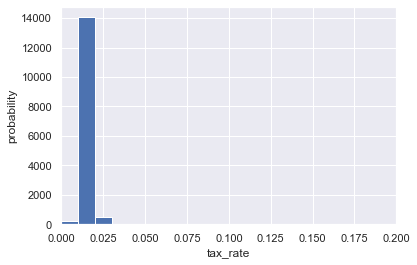

In [49]:
plt.hist(df.tax_rate, density=False, bins=[0, 0.01, 0.02, 0.03, 0.04, 0.05])  # `density=False` would make counts
plt.ylabel('probability')
plt.xlim(0,0.2)
plt.xlabel('tax_rate')

Text(0.5, 0, 'assessed_value')

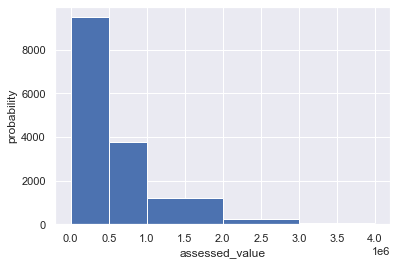

In [50]:
plt.hist(df.assessed_value, density=False, bins =[0, 500000, 1000000, 2000000, 3000000, 4000000])  # `density=False` would make counts
plt.ylabel('probability')
#plt.xlim(0,0.2)
plt.xlabel('assessed_value')

(0.0, 0.04)

<Figure size 864x432 with 0 Axes>

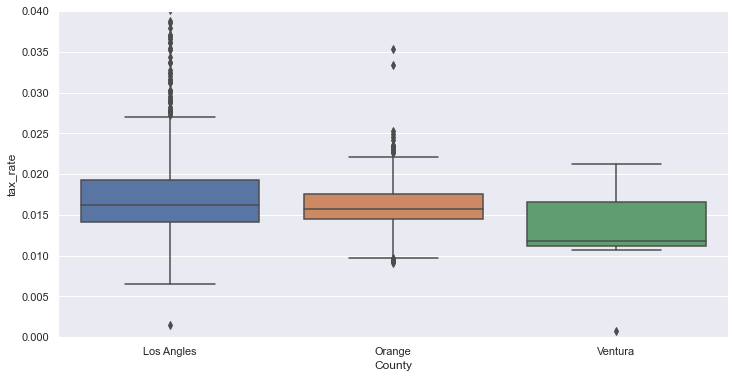

In [51]:
plt.figure(figsize=(12,6))
plt.figure(figsize=(12,6))
sns.boxplot(x= train[train.assessed_value<100000].County, y= train[train.assessed_value<100000].tax_rate, data=train[train.assessed_value<100000])
plt.ylim(0,0.04)

# It seems like tax rate (average) is higher compared to Orange and Ventura counties

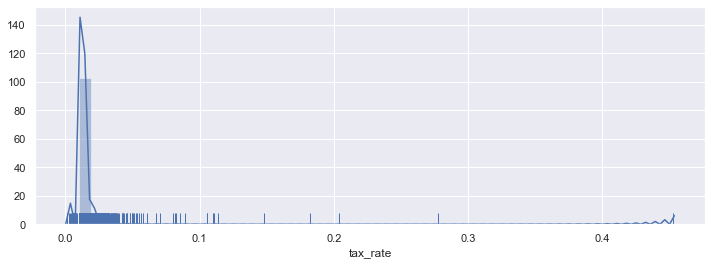

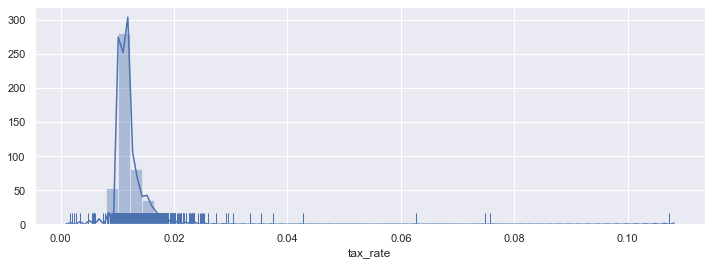

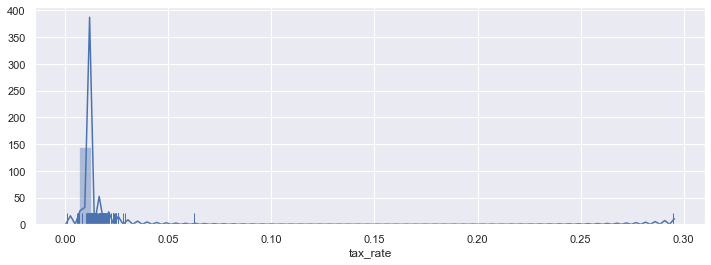

In [52]:
plt.figure(figsize=(12,4))
# below are plots for tax_rate distributions in three counties
sns.distplot(df[df.County == 'Los Angles'].tax_rate, rug=True)
plt.show()
plt.figure(figsize=(12,4))
sns.distplot(df[df.County == 'Orange'].tax_rate, rug=True)
plt.show()
plt.figure(figsize=(12,4))
sns.distplot(df[df.County == 'Ventura'].tax_rate, rug=True)

# Lets see if we can add new features to our model. We start by exploring other variables and their correlation with home values. We will use train data for this exploration

In [53]:
train_plot2 = train[['assessed_value','bedrooms', 'bathrooms', 'square_feet', 'lot_size', 'year_built']]
X_train2 = train[['bedrooms', 'bathrooms', 'square_feet', 'lot_size', 'year_built']]
X_test2 = test[['bedrooms', 'bathrooms', 'square_feet', 'lot_size', 'year_built']]

In [54]:
cm = train_plot2.corr()
cm

,assessed_value,bedrooms,bathrooms,square_feet,lot_size,year_built
assessed_value,1.000,0.264,0.505,0.589,0.132,0.171
bedrooms,0.264,1.000,0.642,0.628,0.087,0.391
bathrooms,0.505,0.642,1.000,0.855,0.160,0.524
square_feet,0.589,0.628,0.855,1.000,0.206,0.464
lot_size,0.132,0.087,0.160,0.206,1.000,0.084
year_built,0.171,0.391,0.524,0.464,0.084,1.000


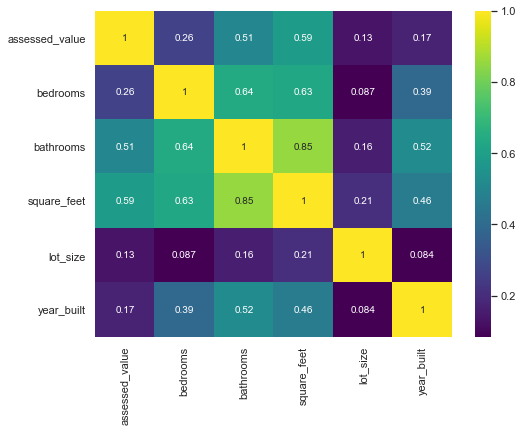

In [55]:
# lets look at heatmap and corresponding correlation values 
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap='viridis')

The heatmap suggests some correlation between lot_size,year_built and home value too.

The histograms above for bedroom, bathroom and square_feet are right skewed. We can possibly tranform the data using log scale to make them more 'normal'

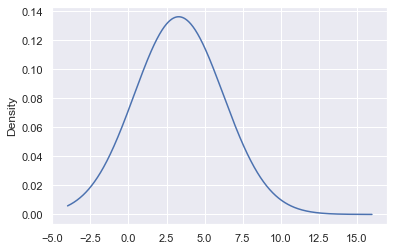

In [56]:
df.bedrooms.plot.kde(bw_method=3)


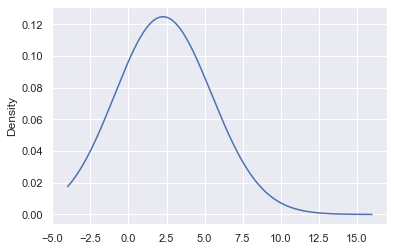

In [57]:
df.bathrooms.plot.kde(bw_method=3)

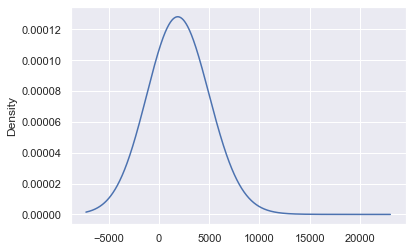

In [58]:
df.square_feet.plot.kde(bw_method=3)

lets use standard scaler and scale all independent variables

In [59]:
#scaler, X_train_scaled,  X_test_scaled= split_scale.robust_scalar_scaler(X_train2, X_test2)
scaler, X_train_scaled, X_test_scaled = split_scale.iqr_robust_scaler(X_train2, X_test2)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12a7c5790>,
      dtype=object)

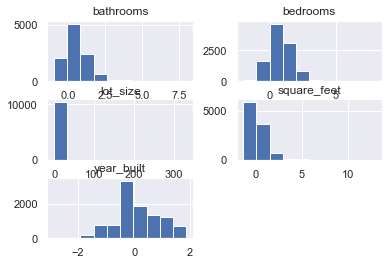

In [60]:
X_train_scaled.hist()

In [61]:
y_train = train[['assessed_value']]

In [62]:
lm = LinearRegression()

In [63]:
rfe = RFE(lm, 4)

In [64]:
X_rfe = rfe.fit_transform(X_train_scaled,y_train)

In [65]:
mask = rfe.support_

# select the column names of the features that were selected and convert them to a list for future use. 
rfe_features = X_train_scaled.columns[mask]

# print them out here for our reference
print(f'selected {len(rfe_features)} features:', ', '.join(rfe_features))

selected 4 features: bedrooms, bathrooms, square_feet, year_built


In [66]:
lm = LinearRegression()

In [67]:
lm.fit(X_rfe, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [68]:
print("Linear Model:", lm)

print("intercept: ", lm.intercept_)

print("features: ", rfe_features)
print("coefficients: ", lm.coef_)

Linear Model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
intercept:  [443159.20546056]
features:  Index(['bedrooms', 'bathrooms', 'square_feet', 'year_built'], dtype='object')
coefficients:  [[-137557.52383447   97862.94724899  499392.7646885  -116826.56048029]]


In [69]:
X_rfe

array([[ 0.        ,  1.        ,  0.4249531 ,  0.93103448],
       [ 1.        ,  0.        ,  0.02626642, -0.03448276],
       [ 0.        ,  0.        ,  0.31613508, -0.86206897],
       ...,
       [ 0.        ,  0.        , -0.21013133, -0.31034483],
       [ 1.        ,  0.5       ,  0.82363977,  1.4137931 ],
       [ 1.        ,  0.        , -0.19418386,  0.06896552]])

In [70]:
predictions['yhat_lm_rfe'] = lm.predict(X_rfe)

In [71]:
predictions.apply(lambda col: sqrt(mean_squared_error(predictions.actual, col)))

actual             0.000
yhat_lm       571669.882
baseline      734625.255
yhat_lm_rfe   566136.925
dtype: float64

In [72]:
predictions.head()

,actual,yhat_lm,baseline,yhat_lm_rfe
11938,268557.000,718051.869,389610.000,644471.098
790,95849.000,316295.362,389610.000,322747.442
3846,324613.000,606590.711,389610.000,701747.331
14846,499860.000,832519.898,389610.000,755687.080
1469,517777.000,302273.270,389610.000,278539.094


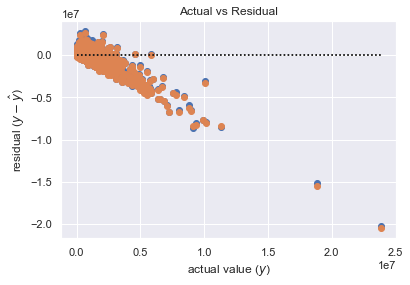

In [73]:
evaluate.plot_residuals(predictions.actual, predictions.yhat_lm_rfe, predictions)
evaluate.plot_residuals(predictions.actual, predictions.yhat_lm, predictions)

# Lets apply Linear Regression model using the selected features above to the test dataset

In [74]:
X_test_scaled.head()

,bedrooms,bathrooms,square_feet,lot_size,year_built
9116,0.000,1.000,1.082,-0.825,0.621
2397,0.000,0.500,1.015,-0.426,1.379
2849,0.000,0.000,-0.479,0.060,-0.310
14308,2.000,1.000,1.332,0.663,1.793
9780,0.000,0.000,0.305,0.190,0.000


In [75]:
X_test_rfe = rfe.transform(X_test_scaled)

In [76]:
len(X_test_rfe)

4462

In [77]:
y_test1 = test[['assessed_value']]
y_test1['test_prediction'] = lm.predict(X_test_rfe)

In [78]:
print("Linear Model:", lm)

print("intercept: ", lm.intercept_)

print("coefficients: ", lm.coef_)

Linear Model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
intercept:  [443159.20546056]
coefficients:  [[-137557.52383447   97862.94724899  499392.7646885  -116826.56048029]]


In [79]:
y_test1.head()

,assessed_value,test_prediction
9116,1352462.000,1008659.075
2397,797339.000,837838.937
2849,63577.000,240025.759
14308,621836.000,721657.385
9780,362761.000,595413.097


In [80]:
y_test1.apply(lambda col: sqrt(mean_squared_error(y_test1.assessed_value, col)))

assessed_value         0.000
test_prediction   569747.128
dtype: float64

The test data has similar RMSE as train data. This means our model is not overfitted

Lets try this model on test data 

In [81]:
y_test1['test_prediction'] = lm.predict(X_test_scaled_rfe)

NameError: name 'X_test_scaled_rfe' is not defined

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_rfe)

poly.get_feature_names()

In [82]:
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_train.assessed_value)
y_train['yhat_poly'] = lm_poly.predict(X_poly)

NameError: name 'X_poly' is not defined

In [83]:
y_train

,assessed_value
11938,268557.000
790,95849.000
3846,324613.000
14846,499860.000
1469,517777.000
...,...
12119,1321024.000
8039,447349.000
14147,665588.000
6936,518732.000


In [84]:
y_train.apply(lambda col: sqrt(mean_squared_error(y_train.assessed_value, col)))

assessed_value   0.000
dtype: float64

# polynomial model is only marginally better

# Lets try to create new feature with Log scale (I am using Log with base 2). Square feet and lot size are good candidates for log scale

In [85]:
df['log2sf'] = np.log2(df['square_feet'])
df['log2lot_size'] = np.log2(df['lot_size'])
df['log2value'] = np.log2(df['assessed_value'])
df['age'] = 2000-df.year_built

In [86]:
df.head(2)

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date,tax_rate,County,log2sf,log2lot_size,log2value,age
0,2.000,3.000,1458.000,6037,8284,1,97318,1970,34686163.000,-118113100.000,136104.000,2319.900,2017-06-23,0.017,Los Angles,10.510,13.016,17.054,30
1,1.000,2.000,1421.000,6037,6707,0,96018,1911,33999877.000,-118291863.000,35606.000,543.690,2017-06-30,0.015,Los Angles,10.473,12.711,15.120,89


In [87]:
train_plot = df[['bathrooms', 'bedrooms', 'log2sf', 'log2lot_size', 'assessed_value', 'age']]

In [88]:
train_plot.head()

,bathrooms,bedrooms,log2sf,log2lot_size,assessed_value,age
0,2.000,3.000,10.510,13.016,136104.000,30
1,1.000,2.000,10.473,12.711,35606.000,89
2,3.000,4.000,11.311,12.280,880456.000,-3
3,2.000,3.000,10.688,12.834,614000.000,51
4,1.000,2.000,9.437,11.506,274237.000,79


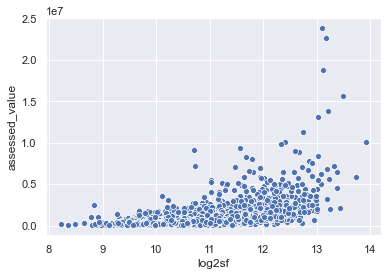

In [89]:
sns.scatterplot(x='log2sf', y = 'assessed_value', data=train_plot)

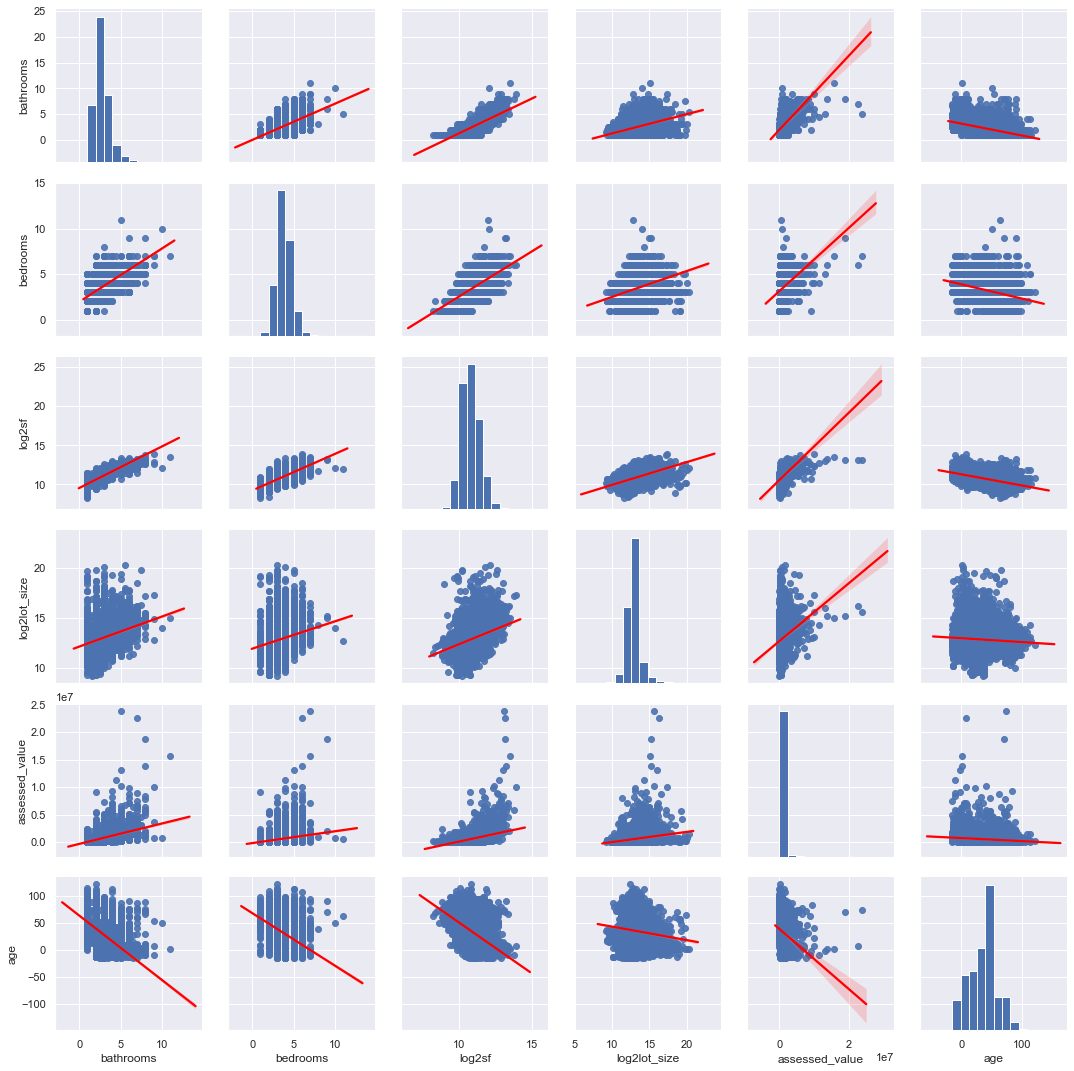

In [90]:
explore.plot_variable_pairs(train_plot)

In [91]:
df[df.County == 'Los Angles'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9513 entries, 0 to 14872
Data columns (total 19 columns):
bathrooms           9513 non-null float64
bedrooms            9513 non-null float64
square_feet         9513 non-null float64
fips                9513 non-null int64
lot_size            9513 non-null int64
pool                9513 non-null int64
zip_code            9513 non-null int64
year_built          9513 non-null int64
latitude            9513 non-null float64
longitude           9513 non-null float64
assessed_value      9513 non-null float64
tax_value           9513 non-null float64
transaction_date    9513 non-null object
tax_rate            9513 non-null float64
County              9513 non-null object
log2sf              9513 non-null float64
log2lot_size        9513 non-null float64
log2value           9513 non-null float64
age                 9513 non-null int64
dtypes: float64(11), int64(6), object(2)
memory usage: 1.5+ MB


In [92]:
df.to_csv('zillow_cleaned.csv')

In [93]:
df.sort_values(by= 'zip_code', ascending = False)

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date,tax_rate,County,log2sf,log2lot_size,log2value,age
7413,3.000,2.000,2143.000,6037,17176,0,399675,1981,34154731.000,-117954681.000,753001.000,9264.780,2017-06-01,0.012,Los Angles,11.065,14.068,19.522,19
4829,2.000,3.000,1532.000,6037,7547,0,399675,1954,34144897.000,-117953095.000,69537.000,1139.840,2017-05-23,0.016,Los Angles,10.581,12.882,16.085,46
11841,2.000,3.000,1895.000,6037,15772,1,399675,1962,34153603.000,-117953027.000,719700.000,8945.780,2017-06-21,0.012,Los Angles,10.888,13.945,19.457,38
2938,6.000,5.000,4698.000,6037,236449,0,399675,1994,34160173.000,-117973852.000,4548320.000,58943.760,2017-05-12,0.013,Los Angles,12.198,17.851,22.117,6
10886,1.000,2.000,2458.000,6037,210491,0,97344,1967,34609221.000,-117827701.000,284270.000,3496.890,2017-06-16,0.012,Los Angles,11.263,17.683,18.117,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3762,1.000,2.000,792.000,6037,4862,0,95982,1925,33963103.000,-118238311.000,207778.000,3031.930,2017-05-17,0.015,Los Angles,9.629,12.247,17.665,75
4206,1.000,2.000,936.000,6037,3823,0,95982,1901,33964168.000,-118234648.000,242083.000,3432.810,2017-05-19,0.014,Los Angles,9.870,11.900,17.885,99
4580,2.000,3.000,1122.000,6037,5419,0,95982,1914,33985468.000,-118252728.000,216449.000,3182.630,2017-05-22,0.015,Los Angles,10.132,12.404,17.724,86
14203,2.000,3.000,960.000,6037,3255,0,95982,1925,33972686.000,-118244738.000,29991.000,868.170,2017-06-30,0.029,Los Angles,9.907,11.668,14.872,75


In [94]:
train, test = train_test_split(df, train_size = .70, random_state = 100)

In [95]:
X_train3 = train[['bedrooms', 'bathrooms', 'log2sf', 'log2lot_size', 'age']]
X_test3 = test[['bedrooms', 'bathrooms', 'log2sf' , 'log2lot_size', 'age']]

In [96]:
y_train3 = train[['log2value',]]
y_test3 = test[['log2value']]

In [97]:
y_train3.head(2)

,log2value
11938,18.035
790,16.548


In [98]:
lm = LinearRegression()

In [99]:
rfe = RFE(lm, 2)

In [100]:
X_rfe = rfe.fit_transform(X_train3,y_train3)

In [101]:
X_rfe

array([[ 3.        , 11.05663772],
       [ 2.        , 10.73555602],
       [ 2.        , 10.97584797],
       ...,
       [ 2.        , 10.50481899],
       [ 2.5       , 11.31910758],
       [ 2.        , 10.52160044]])

In [102]:
mask = rfe.support_

# select the column names of the features that were selected and convert them to a list for future use. 
rfe_features = X_train3.columns[mask]

# print them out here for our reference
print(f'selected {len(rfe_features)} features:', ', '.join(rfe_features))

selected 2 features: bathrooms, log2sf


In [103]:
lm = LinearRegression()

In [104]:
lm.fit(X_rfe, y_train3)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [105]:
predictions1 = y_train3.copy()

In [106]:
predictions1['y_log_lm'] = lm.predict(X_rfe)

In [107]:
predictions1['median_bl'] = y_train3.log2value.median()

In [108]:
predictions1.head()

,log2value,y_log_lm,median_bl
11938,18.035,18.832,18.572
790,16.548,18.303,18.572
3846,18.308,18.504,18.572
14846,18.931,18.964,18.572
1469,18.982,18.030,18.572


In [109]:
predictions1['actual'] = train['assessed_value']

In [110]:
predictions1['calculated'] = 2**predictions1.y_log_lm

In [111]:
predictions1

,log2value,y_log_lm,median_bl,actual,calculated
11938,18.035,18.832,18.572,268557.000,466653.160
790,16.548,18.303,18.572,95849.000,323400.003
3846,18.308,18.504,18.572,324613.000,371749.488
14846,18.931,18.964,18.572,499860.000,511330.350
1469,18.982,18.030,18.572,517777.000,267673.311
...,...,...,...,...,...
12119,20.333,19.069,18.572,1321024.000,550114.274
8039,18.771,18.027,18.572,447349.000,267179.288
14147,19.344,18.110,18.572,665588.000,282901.844
6936,18.985,18.921,18.572,518732.000,496466.268


(0.0, 6000000.0)

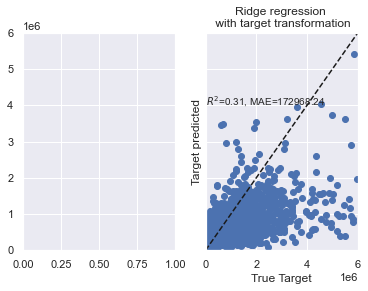

In [112]:
#sns.scatterplot(x= 'actual', y = 'calculated', data = predictions1)
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)
ax1.scatter(predictions1.actual, predictions1.calculated)
ax1.plot([0, 6000000], [0, 6000000], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Ridge regression \n with target transformation')
ax1.text(1, 4000000, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(predictions1.actual, predictions1.calculated), median_absolute_error(predictions1.actual, predictions1.calculated)))
ax1.set_xlim([0, 6000000])
ax1.set_ylim([0, 6000000])

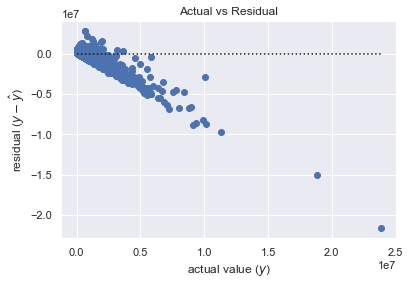

In [113]:
evaluate.plot_residuals(predictions1.actual, predictions1.calculated, predictions1)

In [114]:
predictions1.apply(lambda col: median_absolute_error(predictions1.actual, col))

log2value    389591.428
y_log_lm     389592.039
median_bl    389591.428
actual            0.000
calculated   172968.242
dtype: float64

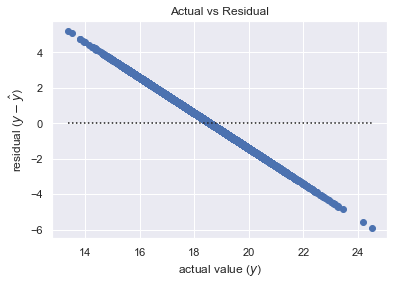

In [115]:
evaluate.plot_residuals(predictions1.log2value, predictions1.median_bl, predictions1)

In [116]:
from sklearn.metrics import median_absolute_error
predictions1.apply(lambda col: median_absolute_error(predictions1.log2value, col))

log2value         0.000
y_log_lm          0.727
median_bl         0.815
actual       389591.428
calculated   326235.226
dtype: float64

In [117]:
y_train3.log2value.median()

18.57167118154203

In [118]:
2**y_train3.log2value.median()

389610.0000000002

In [119]:
2**0.733594

1.6627761961563623

In [120]:
2**0.814753

1.7589969728468688

# lets transform y variable too

In [121]:
df.head(2)

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date,tax_rate,County,log2sf,log2lot_size,log2value,age
0,2.000,3.000,1458.000,6037,8284,1,97318,1970,34686163.000,-118113100.000,136104.000,2319.900,2017-06-23,0.017,Los Angles,10.510,13.016,17.054,30
1,1.000,2.000,1421.000,6037,6707,0,96018,1911,33999877.000,-118291863.000,35606.000,543.690,2017-06-30,0.015,Los Angles,10.473,12.711,15.120,89


Text(0.5, 0, 'assessed_value')

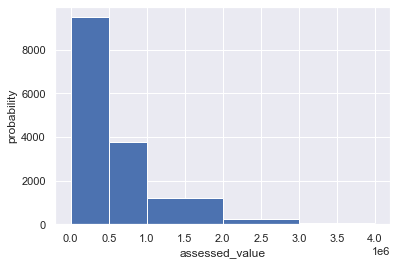

In [122]:
plt.hist(df.assessed_value, density=False, bins =[0, 500000, 1000000, 2000000, 3000000, 4000000])  # `density=False` would make counts
plt.ylabel('probability')
plt.xlabel('assessed_value')

In [123]:
y = df[['assessed_value']]
#y = np.exp((y + abs(y.min())) / 200)
#y_trans = np.log1p(y)

In [124]:
y_trans = quantile_transform(y,
                             n_quantiles=300,
                             output_distribution='normal',
                             copy=True).squeeze()

Text(0.5, 0, 'assessed_value')

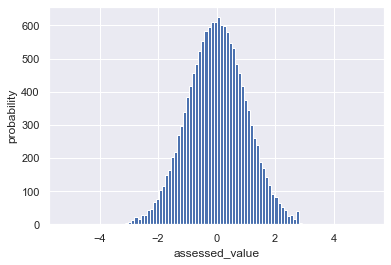

In [125]:
plt.hist(y_trans, density=False, bins =100)  # `density=False` would make counts
plt.ylabel('probability')
plt.xlabel('assessed_value')

In [126]:
train, test = train_test_split(df, train_size=.80, random_state=123)

In [127]:
X_train3 = train[['bedrooms', 'bathrooms', 'log2sf', 'log2lot_size', 'age']]
X_test3 = test[[ 'bedrooms','bathrooms', 'log2sf' , 'log2lot_size' ,'age']]
y_train3 = train[['assessed_value']]
y_test3 = test[['assessed_value']]

In [128]:
from sklearn.linear_model import RidgeCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import median_absolute_error, r2_score

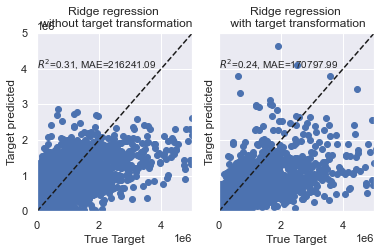

In [129]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

regr = RidgeCV()
regr.fit(X_train3, y_train3)
y_pred = regr.predict(X_train3)

ax0.scatter(y_train3, y_pred)
ax0.plot([0, 5000000], [0, 5000000], '--k')
ax0.set_ylabel('Target predicted')
ax0.set_xlabel('True Target')
ax0.set_title('Ridge regression \n without target transformation')
ax0.text(1, 4000000, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_train3, y_pred), median_absolute_error(y_train3, y_pred)))
ax0.set_xlim([0, 5000000])
ax0.set_ylim([0, 5000000])

regr_trans = TransformedTargetRegressor(
    regressor=RidgeCV(),
    transformer=QuantileTransformer(n_quantiles=300,
                                    output_distribution='normal'))
regr_trans.fit(X_train3, y_train3)
y_pred = regr_trans.predict(X_train3)

ax1.scatter(y_train3, y_pred)
ax1.plot([0, 5000000], [0, 5000000], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Ridge regression \n with target transformation')
ax1.text(1, 4000000, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_train3, y_pred), median_absolute_error(y_train3, y_pred)))
ax1.set_xlim([0, 5000000])
ax1.set_ylim([0, 5000000])

#f.suptitle("Boston housing data: distance to employment centers", y=0.035)
f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

plt.show()

In [130]:
train, test = train_test_split(df, train_size=.80, random_state=123)

In [131]:
X_train4 = train[['bathrooms', 'log2sf']][train.assessed_value<500000]
y_train4 = train[['log2value']][train.assessed_value<500000]

In [132]:
#X_train4 = [train.assessed_value<1000000].train[['bedrooms', 'bathrooms', 'log2sf', 'log2lot_size', 'age']]
X_test4 = test[[ 'bathrooms', 'log2sf']]
#y_train4 = train[['assessed_value']]
y_test4 = test[['log2value']]

In [133]:
X_train4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7606 entries, 10631 to 11646
Data columns (total 2 columns):
bathrooms    7606 non-null float64
log2sf       7606 non-null float64
dtypes: float64(2)
memory usage: 178.3 KB


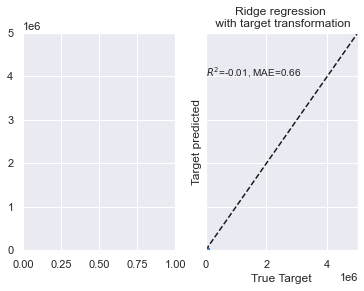

In [134]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# regr = RidgeCV()
# regr.fit(X_train4, y_train4)
# y_pred = regr.predict(X_train4)

# ax0.scatter(y_train4, y_pred)
# ax0.plot([0, 5000000], [0, 5000000], '--k')
# ax0.set_ylabel('Target predicted')
# ax0.set_xlabel('True Target')
# ax0.set_title('Ridge regression \n without target transformation')
# ax0.text(1, 4000000, r'$R^2$=%.2f, MAE=%.2f' % (
#     r2_score(y_train4, y_pred), median_absolute_error(y_train4, y_pred)))
# ax0.set_xlim([0, 5000000])
# ax0.set_ylim([0, 5000000])

regr_trans = TransformedTargetRegressor(
    regressor=RidgeCV(),
    transformer=QuantileTransformer(n_quantiles=300,
                                    output_distribution='normal'))
regr_trans.fit(X_train4, y_train4)
y_pred = regr_trans.predict(X_train4)

ax1.scatter(y_train4, y_pred)
ax1.plot([0, 5000000], [0, 5000000], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Ridge regression \n with target transformation')
ax1.text(1, 4000000, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_train4, y_pred), median_absolute_error(y_train4, y_pred)))
ax1.set_xlim([0, 5000000])
ax1.set_ylim([0, 5000000])

#f.suptitle("Boston housing data: distance to employment centers", y=0.035)
#f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

plt.show()

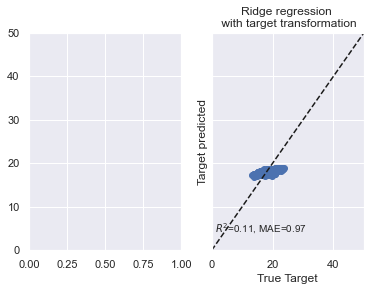

In [135]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

#regr_trans.fit(X_test4, y_test4)
y_pred = regr_trans.predict(X_test4)

ax1.scatter(y_test4, y_pred)
ax1.plot([0, 50], [0, 50], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Ridge regression \n with target transformation')
ax1.text(1, 4, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(y_test4, y_pred), median_absolute_error(y_test4, y_pred)))
ax1.set_xlim([0, 50])
ax1.set_ylim([0, 50])

#f.suptitle("Boston housing data: distance to employment centers", y=0.035)
#f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

plt.show()

In [136]:
df.log2value.min()

13.358651200892886

In [137]:
df.log2value.max()

24.507992387794925

In [138]:
2**df.log2value.min()

10503.999999999996

In [139]:
2**df.log2value.max()

23858374.000000007

In [140]:
2**y_pred

array([[272595.38122961],
       [275311.60827773],
       [248869.19241781],
       ...,
       [153575.59098341],
       [268168.64123311],
       [442147.85373664]])

In [141]:
test.assessed_value

5884    127320.000
1583    576498.000
13532   161853.000
12732   357559.000
11248   355506.000
           ...    
2375    196992.000
4783     21902.000
5618     30399.000
10128   176699.000
3031    481004.000
Name: assessed_value, Length: 2975, dtype: float64

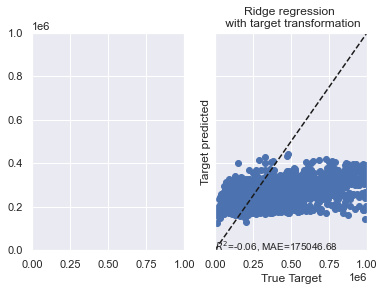

In [142]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)
#regr_trans.fit(X_test4, y_test4)
#y_pred = regr_trans.predict(X_test4)

ax1.scatter(test.assessed_value, 2**y_pred)
ax1.plot([0, 1000000], [0, 1000000], '--k')
ax1.set_ylabel('Target predicted')
ax1.set_xlabel('True Target')
ax1.set_title('Ridge regression \n with target transformation')
ax1.text(1, 4, r'$R^2$=%.2f, MAE=%.2f' % (
    r2_score(test.assessed_value, 2**y_pred), median_absolute_error(test.assessed_value, 2**y_pred)))
ax1.set_xlim([0, 1000000])
ax1.set_ylim([0, 1000000])

#f.suptitle("Boston housing data: distance to employment centers", y=0.035)
#f.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

plt.show()

# Even with transforming target on log scale, there is no improvement in MAE

# GAM Model

In [143]:
from pygam import LinearGAM, s, f
from pygam.datasets import wage
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from patsy import dmatrix
from matplotlib import pyplot as plt

In [149]:
X_train4 = train[['bathrooms', 'log2sf', 'latitude', 'longitude']]
y_train4 = train[['log2value']]
X_test4 = test[[ 'bathrooms', 'log2sf','latitude', 'longitude']]
y_test4 = test[['log2value']]

In [150]:
X_train4 = X_train4.to_numpy()
y_train4 = y_train4.to_numpy()

In [152]:
X_train4[1]

array([ 2.00000000e+00,  1.04868350e+01,  3.41362400e+07, -1.17885266e+08])

In [153]:
gam_pbs = LinearGAM(s(0)+ s(1) + f(2,3))

In [ ]:
gam_pbs.gridsearch(X_train4,y_train4)

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

In [ ]:
y_pred_pbs = gam_pbs.predict(X_train4)

In [ ]:
y_pred_pbs

In [ ]:
y_pred_pbs = pd.DataFrame(y_pred_pbs)

In [ ]:
y_pred_pbs['actual'] =y_train4

In [ ]:
y_pred_pbs.rename(columns = {'0': 'predicted'}, inplace = True)

In [ ]:
y_pred_pbs

In [ ]:
y_pred_pbs['actual1'] = 2**y_pred_pbs.actual
y_pred_pbs['predicted1'] = 2**y_pred_pbs[0]

In [ ]:
y_pred_pbs.apply(lambda col: median_absolute_error(y_pred_pbs.actual1, col))

In [ ]:
evaluate.plot_residuals(y_pred_pbs.actual1, y_pred_pbs.predicted1, y_pred_pbs)
evaluate.plot_residuals(predictions1.actual, predictions1.calculated, predictions1)